<a href="https://colab.research.google.com/github/AnchitSharma/tensorflow-for-deep-learning-with-python/blob/master/Human_activity_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support as error_metric
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.feature_selection import VarianceThreshold

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Load and Analyse data

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
path = "/content/gdrive/My Drive/UCI_HAR_Dataset/"
train = pd.read_csv(path+"train.csv")
test = pd.read_csv(path+"test.csv")

In [ ]:
train.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,tBodyAcc-max()-Y,tBodyAcc-max()-Z,tBodyAcc-min()-X,tBodyAcc-min()-Y,tBodyAcc-min()-Z,tBodyAcc-sma(),tBodyAcc-energy()-X,tBodyAcc-energy()-Y,tBodyAcc-energy()-Z,tBodyAcc-iqr()-X,tBodyAcc-iqr()-Y,tBodyAcc-iqr()-Z,tBodyAcc-entropy()-X,tBodyAcc-entropy()-Y,tBodyAcc-entropy()-Z,"tBodyAcc-arCoeff()-X,1","tBodyAcc-arCoeff()-X,2","tBodyAcc-arCoeff()-X,3","tBodyAcc-arCoeff()-X,4","tBodyAcc-arCoeff()-Y,1","tBodyAcc-arCoeff()-Y,2","tBodyAcc-arCoeff()-Y,3","tBodyAcc-arCoeff()-Y,4","tBodyAcc-arCoeff()-Z,1","tBodyAcc-arCoeff()-Z,2","tBodyAcc-arCoeff()-Z,3","tBodyAcc-arCoeff()-Z,4","tBodyAcc-correlation()-X,Y","tBodyAcc-correlation()-X,Z","tBodyAcc-correlation()-Y,Z",...,fBodyBodyAccJerkMag-entropy(),fBodyBodyAccJerkMag-maxInds,fBodyBodyAccJerkMag-meanFreq(),fBodyBodyAccJerkMag-skewness(),fBodyBodyAccJerkMag-kurtosis(),fBodyBodyGyroMag-mean(),fBodyBodyGyroMag-std(),fBodyBodyGyroMag-mad(),fBodyBodyGyroMag-max(),fBodyBodyGyroMag-min(),fBodyBodyGyroMag-sma(),fBodyBodyGyroMag-energy(),fBodyBodyGyroMag-iqr(),fBodyBodyGyroMag-entropy(),fBodyBodyGyroMag-maxInds,fBodyBodyGyroMag-meanFreq(),fBodyBodyGyroMag-skewness(),fBodyBodyGyroMag-kurtosis(),fBodyBodyGyroJerkMag-mean(),fBodyBodyGyroJerkMag-std(),fBodyBodyGyroJerkMag-mad(),fBodyBodyGyroJerkMag-max(),fBodyBodyGyroJerkMag-min(),fBodyBodyGyroJerkMag-sma(),fBodyBodyGyroJerkMag-energy(),fBodyBodyGyroJerkMag-iqr(),fBodyBodyGyroJerkMag-entropy(),fBodyBodyGyroJerkMag-maxInds,fBodyBodyGyroJerkMag-meanFreq(),fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",subject,Activity
0,0.288585,-0.020294,-0.132905,-0.995279,-0.983111,-0.913526,-0.995112,-0.983185,-0.923527,-0.934724,-0.567378,-0.744413,0.852947,0.685845,0.814263,-0.965523,-0.999945,-0.999863,-0.994612,-0.994231,-0.987614,-0.943220,-0.407747,-0.679338,-0.602122,0.929294,-0.853011,0.359910,-0.058526,0.256892,-0.224848,0.264106,-0.095246,0.278851,-0.465085,0.491936,-0.190884,0.376314,0.435129,0.660790,...,-1.0,-0.936508,0.346989,-0.516080,-0.802760,-0.980135,-0.961309,-0.973653,-0.952264,-0.989498,-0.980135,-0.999240,-0.992656,-0.701291,-1.000000,-0.128989,0.586156,0.374605,-0.991990,-0.990697,-0.989941,-0.992448,-0.991048,-0.991990,-0.999937,-0.990458,-0.871306,-1.000000,-0.074323,-0.298676,-0.710304,-0.112754,0.030400,-0.464761,-0.018446,-0.841247,0.179941,-0.058627,1,STANDING
1,0.278419,-0.016411,-0.123520,-0.998245,-0.975300,-0.960322,-0.998807,-0.974914,-0.957686,-0.943068,-0.557851,-0.818409,0.849308,0.685845,0.822637,-0.981930,-0.999991,-0.999788,-0.998405,-0.999150,-0.977866,-0.948225,-0.714892,-0.500930,-0.570979,0.611627,-0.329549,0.284213,0.284595,0.115705,-0.090963,0.294310,-0.281211,0.085988,-0.022153,-0.016657,-0.220643,-0.013429,-0.072692,0.579382,...,-1.0,-0.841270,0.532061,-0.624871,-0.900160,-0.988296,-0.983322,-0.982659,-0.986321,-0.991829,-0.988296,-0.999811,-0.993979,-0.720683,-0.948718,-0.271958,-0.336310,-0.720015,-0.995854,-0.996399,-0.995442,-0.996866,-0.994440,-0.995854,-0.999981,-0.994544,-1.000000,-1.000000,0.158075,-0.595051,-0.861499,0.053477,-0.007435,-0.732626,0.703511,-0.844788,0.180289,-0.054317,1,STANDING
2,0.279653,-0.019467,-0.113462,-0.995380,-0.967187,-0.978944,-0.996520,-0.963668,-0.977469,-0.938692,-0.557851,-0.818409,0.843609,0.682401,0.839344,-0.983478,-0.999969,-0.999660,-0.999470,-0.997130,-0.964810,-0.974675,-0.592235,-0.485821,-0.570979,0.273025,-0.086309,0.337202,-0.164739,0.017150,-0.074507,0.342256,-0.332564,0.239281,-0.136204,0.173863,-0.299493,-0.124698,-0.181105,0.608900,...,-1.0,-0.904762,0.660795,-0.724697,-0.928539,-0.989255,-0.986028,-0.984274,-0.990979,-0.995703,-0.989255,-0.999854,-0.993238,-0.736521,-0

In [ ]:
test.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,tBodyAcc-max()-Y,tBodyAcc-max()-Z,tBodyAcc-min()-X,tBodyAcc-min()-Y,tBodyAcc-min()-Z,tBodyAcc-sma(),tBodyAcc-energy()-X,tBodyAcc-energy()-Y,tBodyAcc-energy()-Z,tBodyAcc-iqr()-X,tBodyAcc-iqr()-Y,tBodyAcc-iqr()-Z,tBodyAcc-entropy()-X,tBodyAcc-entropy()-Y,tBodyAcc-entropy()-Z,"tBodyAcc-arCoeff()-X,1","tBodyAcc-arCoeff()-X,2","tBodyAcc-arCoeff()-X,3","tBodyAcc-arCoeff()-X,4","tBodyAcc-arCoeff()-Y,1","tBodyAcc-arCoeff()-Y,2","tBodyAcc-arCoeff()-Y,3","tBodyAcc-arCoeff()-Y,4","tBodyAcc-arCoeff()-Z,1","tBodyAcc-arCoeff()-Z,2","tBodyAcc-arCoeff()-Z,3","tBodyAcc-arCoeff()-Z,4","tBodyAcc-correlation()-X,Y","tBodyAcc-correlation()-X,Z","tBodyAcc-correlation()-Y,Z",...,fBodyBodyAccJerkMag-entropy(),fBodyBodyAccJerkMag-maxInds,fBodyBodyAccJerkMag-meanFreq(),fBodyBodyAccJerkMag-skewness(),fBodyBodyAccJerkMag-kurtosis(),fBodyBodyGyroMag-mean(),fBodyBodyGyroMag-std(),fBodyBodyGyroMag-mad(),fBodyBodyGyroMag-max(),fBodyBodyGyroMag-min(),fBodyBodyGyroMag-sma(),fBodyBodyGyroMag-energy(),fBodyBodyGyroMag-iqr(),fBodyBodyGyroMag-entropy(),fBodyBodyGyroMag-maxInds,fBodyBodyGyroMag-meanFreq(),fBodyBodyGyroMag-skewness(),fBodyBodyGyroMag-kurtosis(),fBodyBodyGyroJerkMag-mean(),fBodyBodyGyroJerkMag-std(),fBodyBodyGyroJerkMag-mad(),fBodyBodyGyroJerkMag-max(),fBodyBodyGyroJerkMag-min(),fBodyBodyGyroJerkMag-sma(),fBodyBodyGyroJerkMag-energy(),fBodyBodyGyroJerkMag-iqr(),fBodyBodyGyroJerkMag-entropy(),fBodyBodyGyroJerkMag-maxInds,fBodyBodyGyroJerkMag-meanFreq(),fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",subject,Activity
0,0.257178,-0.023285,-0.014654,-0.938404,-0.920091,-0.667683,-0.952501,-0.925249,-0.674302,-0.894088,-0.554577,-0.466223,0.717208,0.635502,0.789497,-0.877764,-0.997766,-0.998414,-0.934345,-0.975669,-0.949824,-0.830478,-0.168084,-0.378996,0.246217,0.521204,-0.487793,0.482280,-0.045462,0.211955,-0.134894,0.130858,-0.014176,-0.105971,0.073544,-0.171516,0.040063,0.076989,-0.490546,-0.709003,...,-0.484619,-1.000000,-0.035356,-0.254248,-0.700326,-0.770610,-0.797113,-0.764485,-0.820188,-0.937959,-0.770610,-0.970958,-0.798387,0.179435,-1.000000,-0.047391,-0.467849,-0.761326,-0.890165,-0.907308,-0.895301,-0.917883,-0.909829,-0.890165,-0.994105,-0.898022,-0.234815,-1.000000,0.071645,-0.330370,-0.705974,0.006462,0.162920,-0.825886,0.271151,-0.720009,0.276801,-0.057978,2,STANDING
1,0.286027,-0.013163,-0.119083,-0.975415,-0.967458,-0.944958,-0.986799,-0.968401,-0.945823,-0.894088,-0.554577,-0.806013,0.768031,0.683698,0.796706,-0.969097,-0.999580,-0.999646,-0.997720,-0.994006,-0.973637,-0.950720,-0.302437,-0.348243,-0.404785,0.507492,-0.156495,0.040674,0.272991,0.197566,-0.194556,0.411411,-0.340466,0.077555,-0.084024,0.035305,-0.010083,-0.104983,-0.429134,0.399177,...,-0.723642,-1.000000,-0.491213,-0.215404,-0.666004,-0.924461,-0.916774,-0.919383,-0.917983,-0.991121,-0.924461,-0.995727,-0.933127,-0.218860,-1.000000,-0.031474,-0.090655,-0.461801,-0.951977,-0.938212,-0.938008,-0.949922,-0.986902,-0.951977,-0.998272,-0.951255,-0.431053,-1.000000,-0.401189,-0.121845,-0.594944,-0.083495,0.017500,-0.434375,0.920593,-0.698091,0.281343,-0.083898,2,STANDING
2,0.275485,-0.026050,-0.118152,-0.993819,-0.969926,-0.962748,-0.994403,-0.970735,-0.963483,-0.939260,-0.568512,-0.799116,0.848305,0.667864,0.822442,-0.976782,-0.999954,-0.999570,-0.998720,-0.993456,-0.974266,-0.964976,-0.617916,-0.695490,-0.536693,0.242147,-0.114997,0.032703,0.192385,-0.011945,-0.063363,0.470819,-0.507395,0.188536,-0.231575,0.632120,-0.550708,0.305653,-0.323848,0.279786,...,-0.898000,-1.000000,0.140729,-0.206062,-0.639809,-0.975209,-0.973998,-0.967097,-0.982849,-0.997663,-0.975209,-0.999504,-0.9682

In [ ]:
print(train.isnull().values.any())
print(test.isnull().values.any())

False
False


There is no null values in both train  and test dataframe

The subject column is not going to be helpful so i will drop from both dataset

In [ ]:
train.drop('subject', axis=1, inplace=True)
test.drop('subject', axis=1, inplace=True)

In [ ]:
train.describe()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,tBodyAcc-max()-Y,tBodyAcc-max()-Z,tBodyAcc-min()-X,tBodyAcc-min()-Y,tBodyAcc-min()-Z,tBodyAcc-sma(),tBodyAcc-energy()-X,tBodyAcc-energy()-Y,tBodyAcc-energy()-Z,tBodyAcc-iqr()-X,tBodyAcc-iqr()-Y,tBodyAcc-iqr()-Z,tBodyAcc-entropy()-X,tBodyAcc-entropy()-Y,tBodyAcc-entropy()-Z,"tBodyAcc-arCoeff()-X,1","tBodyAcc-arCoeff()-X,2","tBodyAcc-arCoeff()-X,3","tBodyAcc-arCoeff()-X,4","tBodyAcc-arCoeff()-Y,1","tBodyAcc-arCoeff()-Y,2","tBodyAcc-arCoeff()-Y,3","tBodyAcc-arCoeff()-Y,4","tBodyAcc-arCoeff()-Z,1","tBodyAcc-arCoeff()-Z,2","tBodyAcc-arCoeff()-Z,3","tBodyAcc-arCoeff()-Z,4","tBodyAcc-correlation()-X,Y","tBodyAcc-correlation()-X,Z","tBodyAcc-correlation()-Y,Z",...,fBodyBodyAccJerkMag-energy(),fBodyBodyAccJerkMag-iqr(),fBodyBodyAccJerkMag-entropy(),fBodyBodyAccJerkMag-maxInds,fBodyBodyAccJerkMag-meanFreq(),fBodyBodyAccJerkMag-skewness(),fBodyBodyAccJerkMag-kurtosis(),fBodyBodyGyroMag-mean(),fBodyBodyGyroMag-std(),fBodyBodyGyroMag-mad(),fBodyBodyGyroMag-max(),fBodyBodyGyroMag-min(),fBodyBodyGyroMag-sma(),fBodyBodyGyroMag-energy(),fBodyBodyGyroMag-iqr(),fBodyBodyGyroMag-entropy(),fBodyBodyGyroMag-maxInds,fBodyBodyGyroMag-meanFreq(),fBodyBodyGyroMag-skewness(),fBodyBodyGyroMag-kurtosis(),fBodyBodyGyroJerkMag-mean(),fBodyBodyGyroJerkMag-std(),fBodyBodyGyroJerkMag-mad(),fBodyBodyGyroJerkMag-max(),fBodyBodyGyroJerkMag-min(),fBodyBodyGyroJerkMag-sma(),fBodyBodyGyroJerkMag-energy(),fBodyBodyGyroJerkMag-iqr(),fBodyBodyGyroJerkMag-entropy(),fBodyBodyGyroJerkMag-maxInds,fBodyBodyGyroJerkMag-meanFreq(),fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)"
count,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,...,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000
mean,0.274488,-0.017695,-0.109141,-0.605438,-0.510938,-0.604754,-0.630512,-0.526907,-0.606150,-0.468604,-0.306043,-0.557121,0.523551,0.387386,0.594374,-0.547569,-0.820041,-0.901874,-0.845784,-0.684345,-0.643770,-0.631069,-0.102993,-0.137937,-0.163946,-0.116599,0.102762,-0.037786,0.130477,-0.026229,0.026322,0.159966,-0.019575,0.009420,0.033291,0.036587,-0.078640,-0.125131,-0.193802,0.105005,...,-0.842188,-0.678618,-0.347657,-0.877995,0.178195,-0.312968,-0.615441,-0.693210,-0.692876,-0.674830,-0.726645,-0.885103,-0.693210,-0.874292,-0.719795,-0.087878,-0.889442,-0.046516,-0.253649,-0.565425,-0.779376,-0.792391,-0.772836,-0.811409,-0.871927,-0.779376,-0.935785,-0.771497,-0.284627,-0.898859,0.125293,-0.307009,-0.625294,0.008684,0.002186,0.008726,-0.005981,-0.489547,0.058593,-0.056515
std,0.070261,0.040811,0.056635,0.448734,0.502645,0.418687,0.424073,0.485942,0.414122,0.544547,0.282243,0.293867,0.363594,0.343611,0.297818,0.471808,0.259607,0.126333,0.221983,0.371608,0.371581,0.386569,0.468959,0.437268,0.371363,0.306507,0.246593,0.243635,0.230067,0.257383,0.215001

We see that min = -1 and max = +1 no need for scaling 

In [ ]:
train.dtypes.tail()

angle(tBodyGyroJerkMean,gravityMean)    float64
angle(X,gravityMean)                    float64
angle(Y,gravityMean)                    float64
angle(Z,gravityMean)                    float64
Activity                                 object
dtype: object

They all have the same data type. i.e. mostly float and one object feature. let see what object feature is and extract it from the rest

In [ ]:
object_feature = train.dtypes == np.object
object_feature = train.columns[object_feature]
object_feature

Index(['Activity'], dtype='object')

As we can see, the object data type in both train and test dataset is the activity feature. lets take a closer look

In [ ]:
train["Activity"].value_counts()

LAYING                1407
STANDING              1374
SITTING               1286
WALKING               1226
WALKING_UPSTAIRS      1073
WALKING_DOWNSTAIRS     986
Name: Activity, dtype: int64

we need to encode the Activity column becuase sklearn won't accept the prediction column as categorical labels we need to convert it into numerical labels

In [ ]:
le = LabelEncoder()
for x in [train, test]:
  x['Activity'] = le.fit_transform(x['Activity'])

## Find the features correlation / Relationship between the features



In [ ]:
feature_columns = train.columns[:-1]
# calculate the correlation values
correlated_values = train[feature_columns].corr()

In [ ]:
correlated_values = (correlated_values.stack().to_frame().reset_index().rename(columns = {"level_0": "Feature_1", "level_1": "Feature_2", 0:"Correlations"}))
correlated_values.head()

,Feature_1,Feature_2,Correlations
0,tBodyAcc-mean()-X,tBodyAcc-mean()-X,1.000000
1,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,0.148061
2,tBodyAcc-mean()-X,tBodyAcc-mean()-Z,-0.256952
3,tBodyAcc-mean()-X,tBodyAcc-std()-X,0.000619
4,tBodyAcc-mean()-X,tBodyAcc-std()-Y,-0.021903


In [ ]:
# create an abs_correlation column
correlated_values["abs_correlation"] = correlated_values["Correlations"].abs()
correlated_values.head()

,Feature_1,Feature_2,Correlations,abs_correlation
0,tBodyAcc-mean()-X,tBodyAcc-mean()-X,1.000000,1.000000
1,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,0.148061,0.148061
2,tBodyAcc-mean()-X,tBodyAcc-mean()-Z,-0.256952,0.256952
3,tBodyAcc-mean()-X,tBodyAcc-std()-X,0.000619,0.000619
4,tBodyAcc-mean()-X,tBodyAcc-std()-Y,-0.021903,0.021903


In [ ]:
  # picking the most correlated features
  train_fields = correlated_values.sort_values("Correlations", ascending=False).query('abs_correlation>0.8')
  train_fields.sample(5)

,Feature_1,Feature_2,Correlations,abs_correlation
159846,fBodyAcc-iqr()-X,fBodyBodyAccJerkMag-iqr(),0.950354,0.950354
249889,fBodyGyro-entropy()-X,tBodyGyroMag-sma(),0.915836,0.915836
283650,fBodyAccMag-max(),fBodyAccJerk-mean()-Y,0.829657,0.829657
101501,tBodyGyroJerk-iqr()-Y,fBodyBodyAccJerkMag-energy(),0.866976,0.866976
145529,tBodyGyroJerkMag-iqr(),tBodyAccJerkMag-min(),0.812516,0.812516


## Splitting the data into train and validation

In [ ]:
# Getting the split indexes

split_data = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)
train_idx, val_idx = next(split_data.split(train[feature_columns], train['Activity']))

# creating the dataframes
x_train = train.loc[train_idx, feature_columns]
y_train = train.loc[train_idx, 'Activity']

x_val = train.loc[val_idx, feature_columns]
y_val = train.loc[val_idx, 'Activity']


In [ ]:
y_train.value_counts(normalize=True)

0    0.191411
2    0.186941
1    0.174893
3    0.166731
5    0.145939
4    0.134085
Name: Activity, dtype: float64

In [ ]:
y_val.value_counts(normalize=True)

0    0.191296
2    0.186763
1    0.174977
3    0.166818
5    0.145966
4    0.134180
Name: Activity, dtype: float64

Same ratio of classes in both the train and validation data thanks to StratifiedShuffleSplit

## Predictive Modelling

In [ ]:
lr = LogisticRegression(max_iter=1000)
lr = lr.fit(x_train, y_train)

In [ ]:
rf = RandomForestClassifier(n_estimators=10)
rf = rf.fit(x_train, y_train)

In [ ]:
lr_2 = LogisticRegressionCV(Cs=10, cv=4, penalty='l2', max_iter=1000)
lr_2 = lr_2.fit(x_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


In [ ]:
# predict the classes and probability for each class

y_predict = list()
y_proba = list()


labels = ["lr", "lr_r2", "rf"]
models = [lr, lr_2, rf]

for lab, mod in zip(labels, models):
  y_predict.append(pd.Series(mod.predict(x_val), name = lab))
  y_proba.append(pd.Series(mod.predict_proba(x_val).max(axis=1), name=lab))


y_predict = pd.concat(y_predict, axis = 1)
y_proba = pd.concat(y_proba, axis = 1)

y_predict.head()

,lr,lr_r2,rf
0,0,0,0
1,5,5,5
2,1,1,1
3,0,0,0
4,3,3,3


In [ ]:
y_proba.head(10)

,lr,lr_r2,rf
0,0.995980,0.998332,1.0
1,0.992396,0.996673,1.0
2,0.996494,0.999044,0.9
3,0.999998,1.000000,1.0
4,0.989773,0.995326,0.8
5,0.978118,0.989911,1.0
6,0.999976,0.999997,1.0
7,0.999790,0.999940,1.0
8,0.937311,0.950956,0.8
9,0.999802,0.999946,0.9


## Calculating the Error Metrics

In [ ]:
labels

['lr', 'lr_r2', 'rf']

In [ ]:
metrics = list()
confusion_m = dict()


for lab in labels:
  precision, recall, f_score, _ = error_metric(y_val, y_predict[lab], average='weighted')
  accuracy = accuracy_score(y_val, y_predict[lab])
  confusion_m[lab] = confusion_matrix(y_val, y_predict[lab])
  metrics.append(pd.Series({'Precision': precision, 'Recall': recall, 'F_score':f_score, 'Accuracy': accuracy}, name=lab))

metrics = pd.concat(metrics, axis = 1)


In [ ]:
metrics

,lr,lr_r2,rf
Precision,0.985042,0.985949,0.966044
Recall,0.985041,0.985947,0.966002
F_score,0.985040,0.985947,0.966013
Accuracy,0.985041,0.985947,0.966002


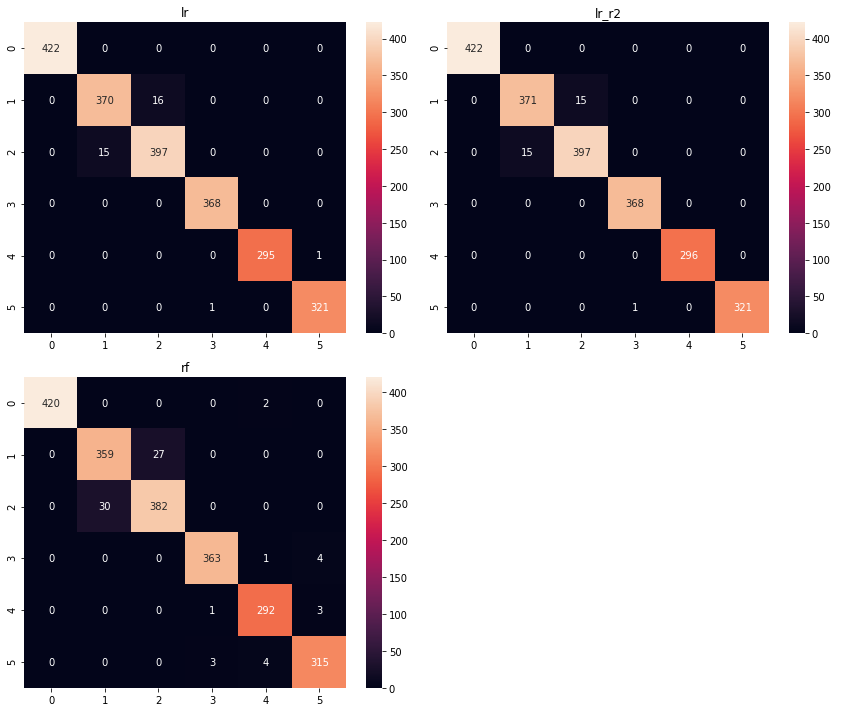

In [31]:
fig, axList = plt.subplots(nrows = 2, ncols = 2)
axList = axList.flatten()
fig.set_size_inches(12, 10)

axList[-1].axis('off')


for ax, lab in zip(axList[:-1], labels):
  sns.heatmap(confusion_m[lab], ax = ax, annot=True, fmt='d')
  ax.set(title=lab)

plt.tight_layout()

Observation:

We can see that the Logistic regression with L2 Regularization gives slightly better error metric than the other models.


## Feature Selection : Discarding the Most Correlated Features

In [33]:
train_fields.sample(5)

,Feature_1,Feature_2,Correlations,abs_correlation
297466,fBodyBodyGyroMag-mad(),tBodyGyro-energy()-X,0.829989,0.829989
308216,fBodyBodyGyroJerkMag-entropy(),tBodyAccJerkMag-std(),0.932996,0.932996
112217,tBodyAccMag-mean(),tBodyAcc-energy()-Y,0.890665,0.890665
103734,tBodyGyroJerk-entropy()-Z,fBodyAccMag-entropy(),0.967202,0.967202
162312,fBodyAcc-entropy()-Z,tBodyGyroJerk-entropy()-Y,0.948892,0.948892


In [34]:
#Getting the features with high Variance and split the data into train and test 
low_var = VarianceThreshold(threshold=(0.8 * (1- 0.8)))

train2 = pd.concat([x_train, x_val])
train_new = pd.DataFrame(low_var.fit_transform(train2))

test_new = pd.concat([y_train, y_val])

x_new, x_val_new = train_test_split(train_new)
y_new, y_val_new = train_test_split(test_new)



## Predictive Models

In [37]:
lr_new = lr.fit(x_new, y_new)


In [38]:
lr_2_new = lr_2.fit(x_new, y_new)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


In [39]:
# predict the classes and probability for each

y_predict_new = list()
y_proba_new = list()


labels_new = ['lr_new', 'lr_l2_new']
models_new = [lr_new, lr_2_new]

for lab, mod in zip(labels_new, models_new):
  y_predict_new.append(pd.Series(mod.predict(x_val_new), name=lab))
  y_proba_new.append(pd.Series(mod.predict_proba(x_val_new).max(axis=1), name=lab))


y_predict_new = pd.concat(y_predict_new, axis = 1)
y_proba_new = pd.concat(y_proba_new, axis=1)

y_predict_new.head()



,lr_new,lr_l2_new
0,2,0
1,3,0
2,0,0
3,2,0
4,1,0


In [46]:
y_predict_new['lr_new']

0       2
1       3
2       0
3       2
4       1
       ..
1833    0
1834    2
1835    3
1836    2
1837    2
Name: lr_new, Length: 1838, dtype: int64

In [47]:
y_val_new

4312    3
542     2
6825    2
6730    3
3717    0
       ..
329     5
6709    0
4389    2
2237    2
5792    3
Name: Activity, Length: 1838, dtype: int64

In [40]:
y_proba_new.head()

,lr_new,lr_l2_new
0,0.208773,0.189144
1,0.194881,0.188044
2,0.209383,0.189484
3,0.205715,0.190622
4,0.204835,0.189249


## Calculating the error metrics

In [45]:
metrics_new = list()
con_mat = list()


for lab in labels_new:
  precision, recall, f_score, _ = error_metric(y_val_new, y_predict_new[lab], average='weighted')

  accuracy = accuracy_score(y_val_new, y_predict_new[lab])
  con_mat[lab] = confusion_matrix(y_val_new, y_predict_new[lab])

  metrics_new.append(pd.Series({'precision': precision, 'recall': recall, 'f_score':f_score, 'accuracy': accuracy}, name=lab))


metrics_new = pd.concat(metrics_new, axis = 1)



TypeError: ignored